In [7]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

n_hidden = np.float128(256.0)
n_dim = np.float128(3.0)

n_iterations = 30
qStart = np.float128(0.0)

def LeakyReLU(x,neg_slope):
    if x >= 0:
        return x
    else:
        return -neg_slope * x

def integrand(z, prev_q):
    return np.tanh(np.sqrt(prev_q) * z)**2 * 1.0/np.sqrt(2.0 * np.pi) * np.exp(-(z**2)/2.0)

def test(z, a):
    return a*z**2

# nextq = weightVar * n_hidden * quad(integrad, -np.inf, np.inf, args=(qStart)) 
# + weightVar * n_dim * (dataVar + dataMean**2) + biasVar
def simulate(weightVar, dataVar, dataMean, biasVar):
    dynamics = np.zeros(n_iterations)
    for i in range(n_iterations):
        if i == 0:
            dynamics[i] = qStart
        else:
            dynamics[i] = weightVar * quad(integrand, -np.inf, np.inf, args=(dynamics[i-1]))[0] \
            + weightVar * (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar
    return dynamics

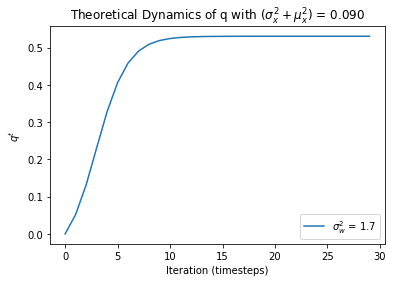

[ 0.          0.05177469  0.13133741  0.23041972  0.3281568   0.40610761
  0.45893894  0.49106192  0.50935183  0.51938363  0.52477432  0.52763932
  0.5291531   0.52995046  0.53036977  0.53059009  0.5307058   0.53076656
  0.53079845  0.5308152   0.53082399  0.5308286   0.53083103  0.5308323
  0.53083296  0.53083331  0.5308335   0.53083359  0.53083365  0.53083367]


In [8]:
weightStd = [1.3]
weightVar = [i**2 for i in weightStd]
biasVar = 0.05
# dataVar = 0
dataVar = 0.089609815596183001
dataMean = 0 # zero-mean
# dataMean = 0.273126
# dataVar = 0.193429 # non-zero mean
plt.figure(1)
for el in weightVar:
    output = simulate(el, dataVar, dataMean, biasVar)
    plt.plot(output, label=r'$\sigma_w^2$ = %.2g' % el)
    plt.xlabel("Iteration (timesteps)")
    plt.ylabel(r'$q^t$')
    plt.title(r'Theoretical Dynamics of q with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()
print(output)

In [5]:
import pickle
import random
data_string = 'lorAtt_30'
with open('lorAttData/%s.pickle' % (data_string), 'rb') as f: #Eventually take the file name as an argument
    data = pickle.load(f)
random.seed(12345)


In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plot
%matplotlib inline

traj = data[random.randint(0,len(data))]
traj = torch.FloatTensor(traj)

hidden_features = 128
n_dim = traj.size()[2]


weight_var = 2.5**2/hidden_features
weight_std = np.sqrt(weight_var)
weight_mean = 0.0
bias_mean = 0.0
bias_std = math.sqrt(0.05)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.activation = nn.Tanh()
        
        for m in self.modules():
                if isinstance(m, torch.nn.Linear):
                    m.weight.data.normal_(weight_mean, weight_std)
                    m.bias.data.normal_(bias_mean, bias_std)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        hidden = self.i2h(combined)
        pre_activation = hidden
        hidden = self.activation(hidden)
        output = self.i2o(combined)
        return output, hidden, pre_activation
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size)) 

10000


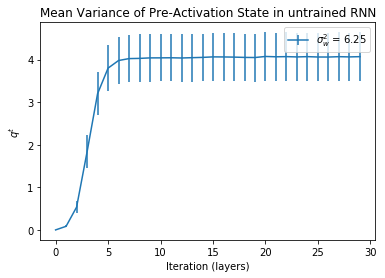

Data Mean = -0.000000
Data Variance = 0.089610
[0.0, 0.084771015, 0.53493118, 1.8338021, 3.1983302, 3.7995238, 3.9783909, 4.0232077, 4.0281973, 4.0398088, 4.0407391, 4.0428543, 4.0377035, 4.0449553, 4.0514479, 4.063529, 4.0618711, 4.0581369, 4.051167, 4.0486069, 4.0733752, 4.0658436, 4.0693951, 4.0626082, 4.0692735, 4.0608935, 4.060297, 4.0682306, 4.0632033, 4.0689855]


In [7]:
variance_all = []
for j in range(len(data)):
    traj = data[j]
    encoderRNN = RNN(n_dim, hidden_features, n_dim)
    decoderRNN = RNN(n_dim, hidden_features, n_dim)
    traj = torch.FloatTensor(traj)

    input_sequence_length = 30
    variances = []
    hidden = encoderRNN.initHidden()
    variances.append(np.var(hidden.data.numpy()[0]))
    traj = Variable(traj)
    output_sequence_length = traj.size()[0] - input_sequence_length

    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim))

    # Run the training sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden, pre_activation = encoderRNN(traj[i], hidden)
        variances.append(np.var(pre_activation.data.numpy()[0]))

    # Now the last hidden state of the encoder is the first hidden state of the decoder.
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput[i], hidden, pre_activation = decoderRNN(dummyState, hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
        else:
            decoderOutput[i], hidden, pre_activation = decoderRNN(decoderOutput[i-1], hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
    if j == 0:
        variance_all = variances
    else:
        variance_all = np.vstack((variance_all, variances))
variance_mean = []
variance_std = []
for i in range(traj.size()[0]):
    variance_mean.append(np.mean(variance_all[:,i]))
    variance_std.append(np.sqrt(np.var(variance_all[:,i])))
print(len(variance_all))
variances = variance_mean
plt.errorbar(range(traj.size()[0]) ,variances, yerr=variance_std,  label=r'$\sigma_w^2$ = %g' % (weight_std**2 * hidden_features))
plt.xlabel("Iteration (layers)")
plt.ylabel(r'$q^t$')
plt.title('Mean Variance of Pre-Activation State in untrained RNN')
plt.legend()
plt.show()
print('Data Mean = %f' % np.mean(data))
print('Data Variance = %f' % np.var(data))
print(variances)

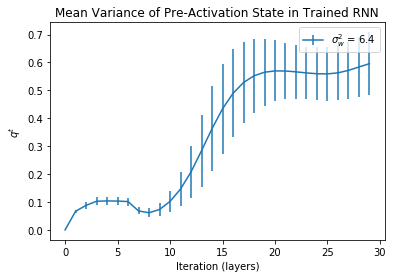

In [8]:
variance_all = []
for j in range(len(data)):
    traj = data[j]
    trainedEncoder = RNN(n_dim, hidden_features, n_dim)
    trainedDecoder = RNN(n_dim, hidden_features, n_dim)
    weight_std = 0.05
    trainedEncoder.load_state_dict(torch.load('savedResults/run_13/TrajModel/lorAtt_30_encoder_wsd_%.2f' % weight_std))
    trainedDecoder.load_state_dict(torch.load('savedResults/run_13/TrajModel/lorAtt_30_decoder_wsd_%.2f' % weight_std))
    traj = torch.FloatTensor(traj)

    input_sequence_length = 6
    variances = []
    hidden = trainedEncoder.initHidden()
    variances.append(np.var(hidden.data.numpy()[0]))
    traj = Variable(traj)
    output_sequence_length = traj.size()[0] - input_sequence_length

    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim))

    # Run the training sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden, pre_activation = trainedEncoder(traj[i], hidden)
        variances.append(np.var(pre_activation.data.numpy()[0]))

    # Now the last hidden state of the encoder is the first hidden state of the decoder.
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput[i], hidden, pre_activation = trainedDecoder(dummyState, hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
        else:
            decoderOutput[i], hidden, pre_activation = trainedDecoder(decoderOutput[i-1], hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
    if j == 0:
        variance_all = variances
    else:
        variance_all = np.vstack((variance_all, variances))
variance_mean = []
variance_std = []
for i in range(traj.size()[0]):
    variance_mean.append(np.mean(variance_all[:,i]))
    variance_std.append(np.sqrt(np.var(variance_all[:,i])))
    
variances = variance_mean
plt.errorbar(range(traj.size()[0]) ,variances, yerr=variance_std,  label=r'$\sigma_w^2$ = %g' % (weight_std*hidden_features))
plt.xlabel("Iteration (layers)")
plt.ylabel(r'$q^t$')
plt.title('Mean Variance of Pre-Activation State in Trained RNN')
plt.legend()
plt.show()

-2.4576883738e-17
0.0896098155962
0.0896098155962


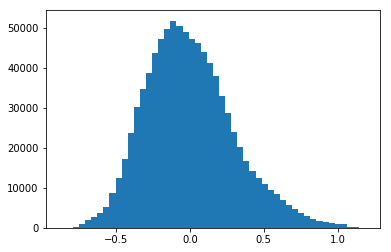

In [9]:
print(np.mean(data))
print(np.var(data))
temp = data.reshape(data.size, 1)
n, bins, patches = plt.hist(temp, 50)
print(np.mean(temp**2))
xvar = np.var(data[:,:,0,0])
yvar = np.var(data[:,:,0,1])
zvar = np.var(data[:,:,0,2])

0.25
[ 0.          0.05026253  0.06171779  0.06406121  0.06453009  0.06462349
  0.06464207  0.06464577  0.06464651  0.06464665  0.06464668  0.06464669
  0.06464669  0.06464669  0.06464669  0.06464669  0.06464669  0.06464669
  0.06464669  0.06464669  0.06464669  0.06464669  0.06464669  0.06464669
  0.06464669  0.06464669  0.06464669  0.06464669  0.06464669  0.06464669]
[0.064646690417683922, 0.014384161661054475, 0.0029288986201334438, 0.00058547640219076824, 0.0001166016474565823, 2.3204866401713153e-05, 4.6173158376738854e-06, 9.1872890903288429e-07, 1.8280271971149453e-07, 3.637285742041918e-08, 7.2372252080121768e-09, 1.4400140663228811e-09, 2.8652424877151361e-10, 5.7010646203892179e-11, 1.1343592731805074e-11, 2.2570695312751354e-12, 4.4909909124868364e-13, 8.9359075694517287e-14, 1.7777446181810319e-14, 3.5388358909926865e-15, 7.0776717819853729e-16, 1.3877787807814457e-16, 2.7755575615628914e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1.0
[ 0.          0.05105012  0.09752688  0.1334

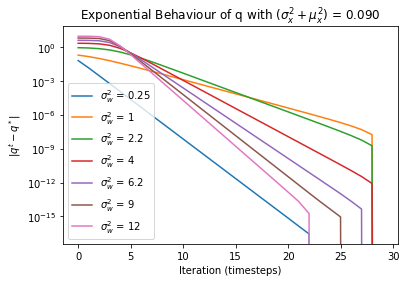

In [9]:
#Exponential Behaviour of abs()
weightStd = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
weightStd = [np.float128(i) for i in weightStd]
weightVar = [i**2 for i in weightStd]
biasVar = np.float128(0.05)
dataVar = np.float128(0.089609815596183001)
dataMean = np.float128(0) # zero-mean
# dataMean = 0.273126
# dataVar = 0.193429 # non-zero mean
plt.figure(3)
for el in weightVar:
    output = simulate(el, dataVar, dataMean, biasVar)
    fixedPoint = output[-1]
    approach = [(np.absolute(q - fixedPoint)) for q in output]
    plt.plot(approach, label=r'$\sigma_w^2$ = %.2g' % el)    
    plt.xlabel("Iteration (timesteps)")
    plt.ylabel(r'$|q^t - q^*|$')
    plt.yscale('log')
    plt.title(r'Exponential Behaviour of q with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
    print(el)
    print(output)
    print(approach)
plt.legend()
plt.show()